In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import itertools as itt

Here are my initial thoughts on how to approach the problem:

* For each arrangement of vertices I can think of:
  * For every permutation of vertices:
    * Make a polygon out of those vertices
    * Toss out the ones where two edges cross
  * Add up the polygons
* See which arrangement has the most polygons

My first question: How can I tell if two line segments intersect? Some googling found a clever answer from Bryce Boe here:
https://bryceboe.com/2006/10/23/line-segment-intersection-algorithm/

Note to self: It assumes noncolinearity of the segment endpoints.

In [2]:
def ccw(a, b, c):
    return (c[1]-a[1]) * (b[0]-a[0]) > (b[1]-a[1]) * (c[0]-a[0])
    # In other words, if the slope of AC > the slope of AB

def intersect(l):
    """Tests if l[0]-l[1] and l[2]-l[3] intersect."""
    a, b, c, d = l
    return ccw(a, c, d) != ccw(b, c, d) and ccw(a, b, c) != ccw(a, b, d)
    # In other words, if line CD splits A and B and line AB splits C and D


I'll store each arrangement of points as a Numpy array of points (N by 2). It will be natural to refer to the point in row 0 as A, row 1 as B, etc. So, here are a few utility functions that will do that:

In [3]:
def name(p):
    """0 -> 'A', 1 -> 'B', 2 -> 'C', etc."""
    return chr(65 + p)

def nameall(l):
    """Returns a map of name() to l in spirit."""
    return ''.join([chr(65 + p) for p in l])


Now, it's time to find the crossings in our arrangement of points. I'll store the crossings as a list of sets of pairs of edges (which are represented by the index of the point in the array). If our array of points is a square with two dots inside of it:
```
[[0, 0], 
 [0, 4], 
 [4, 4], 
 [4, 0], 
 [2, 1], 
 [2, 3]]
```
our list of crossings will be 
```
[{(0, 2), (1, 3)}, 
 {(0, 2), (1, 4)}, 
 {(0, 2), (3, 5)}, 
<snip>
 {(2, 4), (3, 5)}]
```

In [4]:
def find_crosses(pts, verbose=False):
    crossings = [] # list of sets of "lines" 
    
    # This goes through every combination of two line segments.
    # Every line segment is just every combination of two points.
    for p in itt.combinations(itt.combinations(range(len(pts)), 2), 2):
        # p looks like [[0,1], [2,3]]. That's a hassle to subscript,
        # so I made a flat version to use later on.
        flat = [item for sublist in p for item in sublist]
        # It's possible I have two segments that share a vertex. Ignore that.
        if len(set(flat)) == 4:
            if verbose:
                print(f'{name(flat[0])}{name(flat[1])} and',
                      f'{name(flat[2])}{name(flat[3])}', end=' ')
            if intersect(pts[tuple([flat])]):
                if verbose: print('** intersect.')
                crossings.append(set(p))
            else:
                if verbose: print('are distinct.')
    return crossings

Future me who's editing this can tell that I'll want a function that turns an ordered list of vertices into a set of edges of that polygon. Here it is:

In [5]:
def edges(verts):
    ends = list(verts[1:]) + [verts[0]]
    ed = list(zip(verts, ends))
    for i in range(len(ed)):
        ed[i] = tuple(sorted(ed[i]))
    return set(ed)

I wasn't using iPython when I solved this, so I wrote a program to print out what a arrangement of points actually looked like. (I wasn't inspired enough to write something that could print out something resembling polygons.) Two days later, I don't know exactly why my use of `numpy.nonzero` actually works, but it does!

In [6]:
def display_pts(pts):
    # The axis argument tells NumPy to look for the min/max in each column.
    xmax, ymax = pts.max(axis=0)
    xmin, ymin = pts.min(axis=0)
    for y in range(ymax, ymin-1, -1):
        # print the y-axis labels
        print(f'{abs(y)} ', end='')
        for x in range(xmin, xmax+1):
            # If [x, y] is in our list of points...
            p = np.nonzero([x and y for x, y in pts == [x, y]])
            if p[0].size > 0:
                # print its corresponding letter
                print(name(p[0][0]), end='')
            else:
                # print something equivalent to empty
                print(chr(183), end='') # interpunct, hopefully
        print()
    # print the x-axis labels
    print('  ', end='')
    for x in range(xmin, xmax+1):
        print(abs(x), end='')
    print()

It's now time to permute the vertices and otherwise put the rest of the programming together. 

Through the symmetry of the problem, I can throw out large chunks of my search space. If I represent a polygon as a list of its vertices, it doesn't matter which vertex my polygon starts at (ABCDEF and BCDEFA are the same polygon). It also doesn't matter which order I traverse the polygon (ABCDEF and AFEDCB are the same polygon). So, I'll assume A is the first vertex and that the second vertex is less than the last one.

The crossing test takes the list of crossings from `find_crosses()` and uses Python set operations to see if any of the potential sets of edges have a pair of crossing edges. That causes the loop to bail. Otherwise (the `else` clause of the inner `for` loop), the polygon gets added to our list of valid polygons.

This returns a list of valid polygons (that is, a list of numbers representing the vertices in order). I'm typing this Sunday morning; maybe I'll figure out how to use pyplot before I submit the answer.

In [7]:
def polygons(pts, verbose=False):
    size = len(pts)
    crosses = find_crosses(pts)
    polygons = []
    if verbose:
        display_pts(pts)
        print()
        print(f"{len(crosses)} crossings of the complete graph K_{size}.")
    # WOLOG, we can assume vertex 0 is first.
    for most_vertices in itt.permutations(range(1, size)):
        # We'll end up double-counting polygons if we don't do this:
        if most_vertices[0] > most_vertices[-1]:
            continue
        v = [0] + list(most_vertices)
        # v starts with 0 and v[1] is lower than v[-1]
        e = edges(v)
        for x in crosses:
            if e > x: # if e is a proper superset of x
                break
        else: # only called if "for x" doesn't break; i.e. no crossings
            polygons.append(v)
            if verbose: print(nameall(v), "is a valid polygon.")
    if verbose: print(len(polygons), "total polygons.")
    return polygons

Now it's time to test out some arrangements of points. We'll test this out with the 4-vertex examples in the problem's hint. (The names of the sets of points represent how many points are in the convex hull of the set iteratively; p4 is a square, while p31 is a triangle surrounding one point.)

In [8]:
p = {}
p[4] = np.array([[0, 0], [0, 4], [4, 4], [4, 0]])
p[31] = np.array([[0, 0], [4, 0], [2, 4], [2, 1]])

In [9]:
polygons(p[4], True)

4 B···C
3 ·····
2 ·····
1 ·····
0 A···D
  01234

1 crossings of the complete graph K_4.
ABCD is a valid polygon.
1 total polygons.


[[0, 1, 2, 3]]

In [10]:
polygons(p[31], True)

4 ··C··
3 ·····
2 ·····
1 ··D··
0 A···B
  01234

0 crossings of the complete graph K_4.
ABCD is a valid polygon.
ABDC is a valid polygon.
ACBD is a valid polygon.
3 total polygons.


[[0, 1, 2, 3], [0, 1, 3, 2], [0, 2, 1, 3]]

So far, so good. Here are the test arrangments of six points I could come up with:

In [11]:
p[42] = np.array([[0, 0], [0, 4], [4, 4], [4, 0], [2, 1], [2, 3]])
p[33] = np.array([[0,0], [4,0], [2,4], [1,1], [3,1], [2,3]])
p[33.1] = np.array([[0,0], [6,0], [3,6], [2,2], [3,1], [4,2]])
p[6] = np.array([[1,0], [3,0], [4,2], [3,4], [1,4], [0,2]])

Here's a helper function that's a one-argument version of `polygons()` with the `verbose` flag set to `True`:

In [12]:
pgp = lambda x: polygons(x, True) # pgp = PolyGons Print

`p[33]` has two triangles nested inside each other, both pointing up. `p[33.1]` is similar, but the inner triangle is pointing down. Let's see what we get (I don't care about the return value of the function at the moment, so I'll assign it to `_`):

In [13]:
_ = pgp(p[42])

4 B···C
3 ··F··
2 ·····
1 ··E··
0 A···D
  01234

9 crossings of the complete graph K_6.
ABCDEF is a valid polygon.
ABCDFE is a valid polygon.
ABCFDE is a valid polygon.
ABCFED is a valid polygon.
ABEFCD is a valid polygon.
ABFCDE is a valid polygon.
ABFCED is a valid polygon.
ABFECD is a valid polygon.
ADCBFE is a valid polygon.
ADCFBE is a valid polygon.
ADECBF is a valid polygon.
ADFCBE is a valid polygon.
AEDCBF is a valid polygon.
13 total polygons.


In [14]:
_ = pgp(p[33])

4 ··C··
3 ··F··
2 ·····
1 ·D·E·
0 A···B
  01234

3 crossings of the complete graph K_6.
ABCDFE is a valid polygon.
ABCEDF is a valid polygon.
ABCEFD is a valid polygon.
ABCFDE is a valid polygon.
ABCFED is a valid polygon.
ABDECF is a valid polygon.
ABDEFC is a valid polygon.
ABDFEC is a valid polygon.
ABECFD is a valid polygon.
ABEDFC is a valid polygon.
ABEFCD is a valid polygon.
ABEFDC is a valid polygon.
ABFCDE is a valid polygon.
ABFEDC is a valid polygon.
ACBDEF is a valid polygon.
ACBEDF is a valid polygon.
ACBEFD is a valid polygon.
ACBFDE is a valid polygon.
ACBFED is a valid polygon.
ACDFBE is a valid polygon.
ACEBDF is a valid polygon.
ACFBED is a valid polygon.
ACFEBD is a valid polygon.
ADBCEF is a valid polygon.
ADBECF is a valid polygon.
ADCBFE is a valid polygon.
ADCFBE is a valid polygon.
ADEBCF is a valid polygon.
ADFCBE is a valid polygon.
29 total polygons.


In [15]:
_ = pgp(p[33.1])

6 ···C···
5 ·······
4 ·······
3 ·······
2 ··D·F··
1 ···E···
0 A·····B
  0123456

6 crossings of the complete graph K_6.
ABCDFE is a valid polygon.
ABCFDE is a valid polygon.
ABCFED is a valid polygon.
ABEDFC is a valid polygon.
ABEFCD is a valid polygon.
ABEFDC is a valid polygon.
ABFCDE is a valid polygon.
ABFCED is a valid polygon.
ABFECD is a valid polygon.
ABFEDC is a valid polygon.
ACBEFD is a valid polygon.
ACBFDE is a valid polygon.
ACBFED is a valid polygon.
ACDFBE is a valid polygon.
ACFBDE is a valid polygon.
ACFBED is a valid polygon.
ACFDBE is a valid polygon.
ADCBEF is a valid polygon.
ADCBFE is a valid polygon.
ADCFBE is a valid polygon.
ADFCBE is a valid polygon.
AEBCDF is a valid polygon.
22 total polygons.


In [16]:
_ = pgp(p[6])

4 ·E·D·
3 ·····
2 F···C
1 ·····
0 ·A·B·
  01234

15 crossings of the complete graph K_6.
ABCDEF is a valid polygon.
1 total polygons.


My hypothesis is that as the crossing number of the planar arrangement of the complete graph of each arrangement of vertices increases, the number of polygons decreases. As it turns out, for six vertices, the minimum crossing number for $K_6$ is 3, as exhibited by `p33`. `p33` can form 29 hexagons, as shown above.

## Answer to Riddler Classic: 29

For heptagons, my first instinct was a triangle around a triangle around a point (making sure no three points are colinear). Then, I thought of a triangle around a square and a square around a triangle. I got tired of making sure my brackets were nested properly, so I typed the numbers as a flat array and `reshape()`d them into however many rows (what the `-1` represents) and 2 columns.

In [17]:
p[331] = np.array([0,0, 8,0, 4,8, 1,1, 7,1, 4,6, 3,2]).reshape((-1, 2))
p[34]  = np.array([0,0, 8,0, 4,8, 5,2, 5,4, 3,4, 3,2]).reshape((-1, 2))
p[43]  = np.array([0,0, 4,0, 4,4, 0,4, 1,1, 3,1, 2,3]).reshape((-1, 2))

In [18]:
for a in (331, 34, 43):
    print('Arrangement', a, 'has', len(find_crosses(p[a])), "crosses", end=' ')
    print('and', len(polygons(p[a])), 'polygons.')

Arrangement 331 has 9 crosses and 91 polygons.
Arrangement 34 has 15 crosses and 67 polygons.
Arrangement 43 has 19 crosses and 44 polygons.


Again, as it turns out, 9 is the minimum crossing number for $K_7$. That's met by `p331`. Therefore:

## Answer to Riddler Classic extra credit: 91

I hadn't really messed around with plotting in these notebooks before, but it's surprisingly simple.

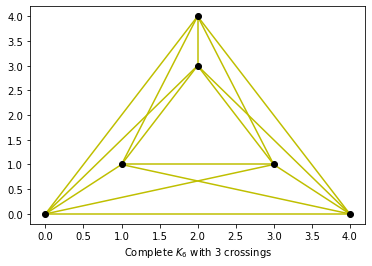

In [29]:
for i, j in itt.combinations(range(6), 2):
    plt.plot([p[33][i][0], p[33][j][0]], [p[33][i][1], p[33][j][1]], 'y-')
plt.plot(*p[33].T, 'ko')
plt.xlabel('Complete $K_6$ with 3 crossings')
plt.show()

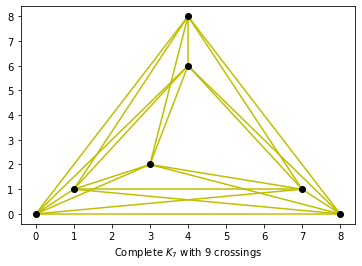

In [31]:
for i, j in itt.combinations(range(7), 2):
    plt.plot([p[331][i][0], p[331][j][0]], [p[331][i][1], p[331][j][1]], 'y-')
plt.plot(*p[331].T, 'ko')
plt.xlabel('Complete $K_7$ with 9 crossings')
plt.show()

I found the book [*Crossing Numbers of Graphs*](https://books.google.com/books?id=khFFDwAAQBAJ&lpg=SA1-PA4&ots=WGmSjDEHAJ&dq=k7%20with%20straight%20edges%20and%20minimal%20crossings&pg=SA1-PA5#v=onepage&q&f=false) by Marcus Schaefer. Figure 1-5 contains graphs that look a lot like the two above.

In [52]:
def plot_polygon(v, pts):
    plt.plot(*np.append(pts[tuple([v])], [[0,0]], axis=0).T)
    plt.axis('off')

In [53]:
def plot_all_polygons(pts, cols=4):
    plt.figure(figsize=(20,20))
    polys = polygons(pts)
    rows = len(polys) // cols + 1
    for i, p in enumerate(polys):
        plt.subplot(rows, cols, i+1)
        plot_polygon(p, pts)
    plt.show()

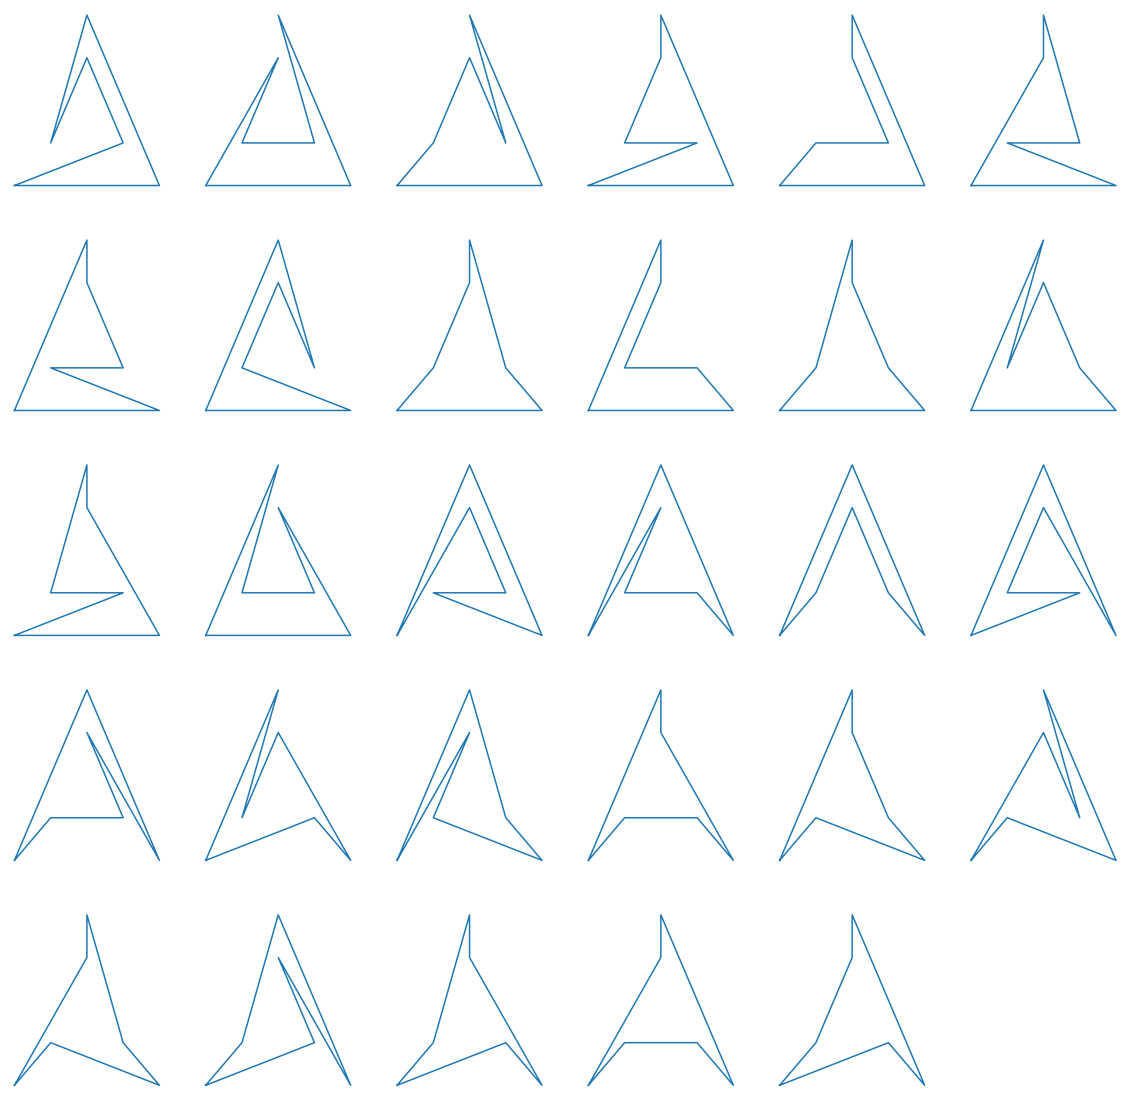

In [54]:
plot_all_polygons(p[33], cols=6)

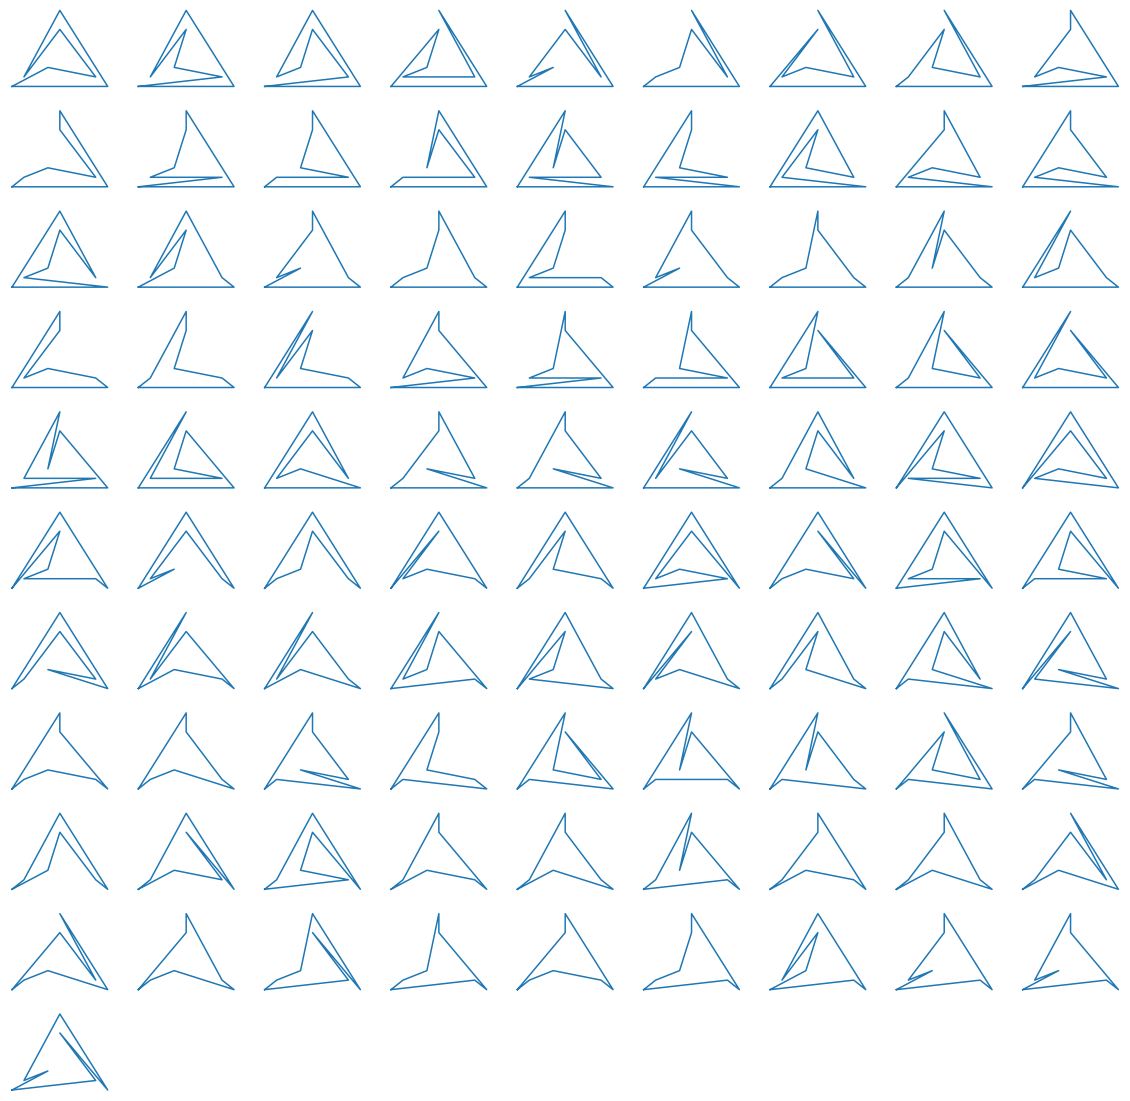

In [58]:
plot_all_polygons(p[331], cols=9)

Let's look at pentagons, since we skipped that.

In [61]:
p[41]  = np.array([0,0, 4,0, 4,4, 0,4, 2,1]).reshape((-1, 2))
p[32]  = np.array([0,0, 4,0, 2,4, 1,1, 3,1]).reshape((-1, 2))

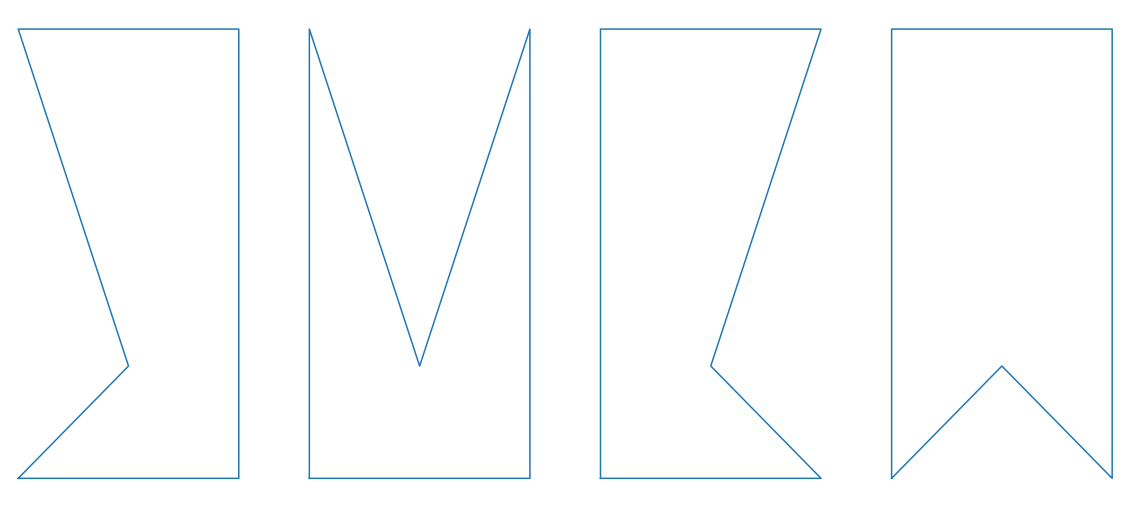

In [62]:
plot_all_polygons(p[41])

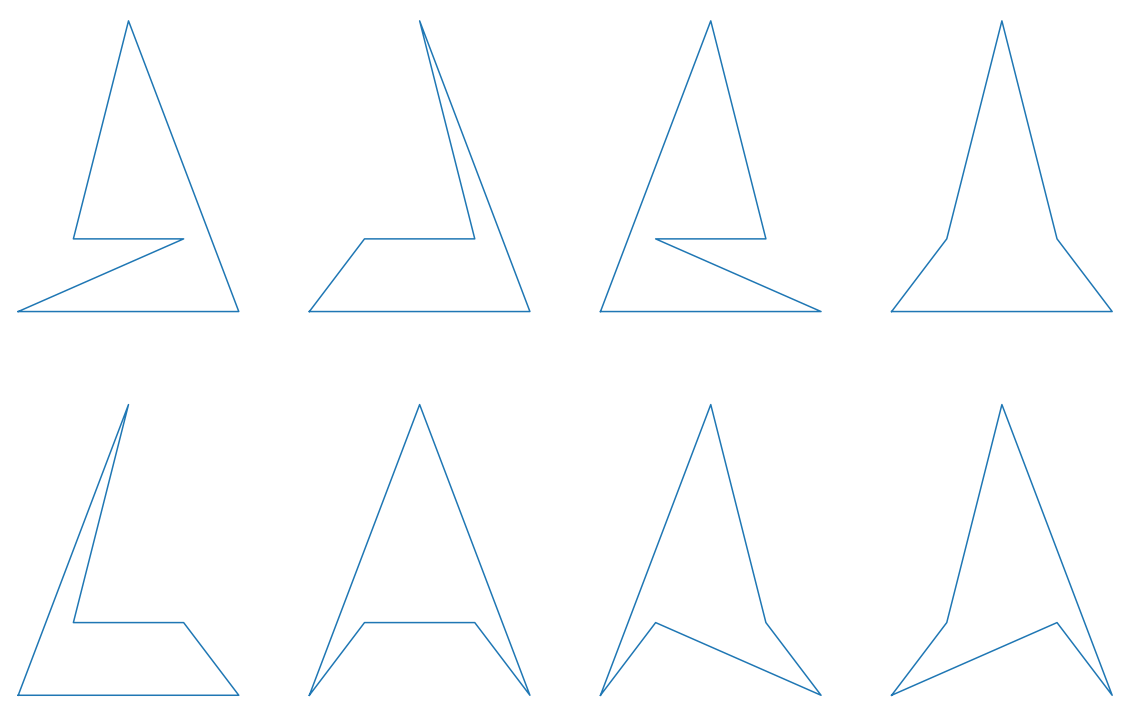

In [63]:
plot_all_polygons(p[32])

In [64]:
find_crosses(p[32], True)

AB and CD are distinct.
AB and CE are distinct.
AB and DE are distinct.
AC and BD are distinct.
AC and BE are distinct.
AC and DE are distinct.
AD and BC are distinct.
AD and BE are distinct.
AD and CE are distinct.
AE and BC are distinct.
AE and BD ** intersect.
AE and CD are distinct.
BC and DE are distinct.
BD and CE are distinct.
BE and CD are distinct.


[{(0, 4), (1, 3)}]

There's only one crossing in `p[32]`, so I'm fairly sure that 8 is the answer for pentagons.

To my surprise, 1, 3, 8, 29, 91 isn't in OEIS. I was hoping to find a general formula based on the crossing number of $K_n$ and $\frac{(n-1)!}{2}$. Either it's not in there, or there's an error in my code that's too subtle for me to pick up on and only manifests itself in higher levels.